DATA Processing

In [16]:
import pandas as pd
import numpy as np

# Load the dataset with appropriate encoding
file_path = "SeoulBikeData.csv"
df = pd.read_csv(file_path, encoding='ISO-8859-1')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       8760 non-null   object 
 1   Rented Bike Count          8760 non-null   int64  
 2   Hour                       8760 non-null   int64  
 3   Temperature(°C)            8760 non-null   float64
 4   Humidity(%)                8760 non-null   int64  
 5   Wind speed (m/s)           8760 non-null   float64
 6   Visibility (10m)           8760 non-null   int64  
 7   Dew point temperature(°C)  8760 non-null   float64
 8   Solar Radiation (MJ/m2)    8760 non-null   float64
 9   Rainfall(mm)               8760 non-null   float64
 10  Snowfall (cm)              8760 non-null   float64
 11  Seasons                    8760 non-null   object 
 12  Holiday                    8760 non-null   object 
 13  Functioning Day            8760 non-null   objec

In [17]:
# Step 1: Rename columns to consistent format
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '').str.replace('/', '_')

# Step 2: Parse date and sort data by date and hour
df['datetime'] = pd.to_datetime(df['date'], format='%d/%m/%Y') + pd.to_timedelta(df['hour'], unit='h')
df.sort_values(by='datetime', inplace=True)

# Step 3: Create lagged features (e.g., 1-hour lag)
df['lag1'] = df['rented_bike_count'].shift(1)

# Step 4: Drop rows with missing values (due to lag)
df.dropna(inplace=True)

# Step 5: Encode categorical variables
df['holiday'] = df['holiday'].astype('category')
df['functioning_day'] = df['functioning_day'].astype('category')
df['seasons'] = df['seasons'].astype('category')

# One-hot encode categorical features
df = pd.get_dummies(df, columns=['holiday', 'functioning_day', 'seasons'], drop_first=True)

# Step 6: Time-aware train-test split (80/20)
train_size = int(0.8 * len(df))
train = df.iloc[:train_size].copy()
test = df.iloc[train_size:].copy()

# Return shapes of train and test datasets to confirm success
train.shape, test.shape


((7007, 18), (1752, 18))

GLM with Negative Binomial Regression with Lag Variables

Baseline Model

In [18]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from numpy import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error



# Step 1: Define the model formula
# We'll include weather features, time-based variables, and the lagged bike count
nb_formula = (
    "rented_bike_count ~ lag1 + Q('temperature°c') + Q('humidity%') + Q('wind_speed_m_s') + "
    "Q('visibility_10m') + Q('dew_point_temperature°c') + Q('solar_radiation_mj_m2') + "
    "Q('rainfallmm') + Q('snowfall_cm') + hour + "
    "Q('holiday_No Holiday') + Q('functioning_day_Yes') + "
    "Q('seasons_Spring') + Q('seasons_Summer') + Q('seasons_Winter')"
)

# Step 2: Fit the Negative Binomial GLM
nb_model_benchmark = smf.glm(
    formula=nb_formula,
    data=train,
    family=sm.families.NegativeBinomial()
).fit()



glm_pred_full = nb_model_benchmark.predict(test)
rmse_full = sqrt(mean_squared_error(test['rented_bike_count'], glm_pred_full))
mae_full = mean_absolute_error(test['rented_bike_count'], glm_pred_full)

# Step 3: Summary of the model
nb_model_benchmark.summary()

d:\Software\Anaconda3\envs\PythonAndR\Lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:      rented_bike_count   No. Observations:                 7007
Model:                            GLM   Df Residuals:                     6991
Model Family:        NegativeBinomial   Df Model:                           15
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -49725.
Date:                Sun, 23 Mar 2025   Deviance:                       2132.2
Time:                        21:05:24   Pearson chi2:                 2.28e+03
No. Iterations:                   100   Pseudo R-squ. (CS):             0.5879
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                          -39.0444   7.91e+06  -4.94e-06      1.000   -1.55e+07    1.55e+07
Q('holiday_No Holiday')[T.True]      0.2668      0.059      4.520      0.000       0.151       0.382
Q('functioning_day_Yes')[T.True]    45.0985   7.91e+06    5.7e-06      1.000   -1.55e+07    1.55e+07
Q('seasons_Spring')[T.True]         -0.0101      0.064     -0.158      0.874      -0.135       0.114
Q('seasons_Summer')[T.True]         -0.0781      0.055     -1.423      0.155      -0.186       0.029
Q('seasons_Winter')[T.True]         -0.2057      0.088     -2.329      0.020      -0.379      -0.033
lag1                                 0.0009   2.74e-05     34.310      0.000       0.001       0.001
Q('temperature°c')                  -0.0159      0.009     -1.757      0.079      -0.034       0.002
Q('humidity%')                      -0.0136      0.003     -5.336      0.000      -0.019      -0.009
Q('wind_speed_m_s')                 -0.0198      0.013     -1.518      0.129      -0.045       0.006
Q('visibility_10m')              -7.316e-06    2.7e-05     -0.271      0.787   -6.03e-05    4.57e-05
Q('dew_point_temperature°c')         0.0365      0.009      3.861      0.000       0.018       0.055
Q('solar_radiation_mj_m2')           0.1081      0.020      5.524      0.000       0.070       0.146
Q('rainfallmm')                     -0.0899      0.011     -8.303      0.000      -0.111      -0.069
Q('snowfall_cm')                    -0.1066      0.032     -3.356      0.001      -0.169      -0.044
hour                                 0.0123      0.002      5.927      0.000       0.008       0.016
====================================================================================================
"""

Final Model

In [19]:
# Remove functioning_day_Yes from the model formula

# Step 1: Define the model formula
# We'll include weather features, time-based variables, and the lagged bike count
nb_formula = (
    "rented_bike_count ~ lag1 + Q('temperature°c') + Q('humidity%') + Q('wind_speed_m_s') + "
    "Q('visibility_10m') + Q('dew_point_temperature°c') + Q('solar_radiation_mj_m2') + "
    "Q('rainfallmm') + Q('snowfall_cm') + hour + "
    "Q('holiday_No Holiday') + "
    "Q('seasons_Spring') + Q('seasons_Summer') + Q('seasons_Winter')"
)

# Step 2: Fit the Negative Binomial GLM
nb_model = smf.glm(
    formula=nb_formula,
    data=train,
    family=sm.families.NegativeBinomial()
).fit()

# Step 3: Summary of the model
nb_model.summary()



d:\Software\Anaconda3\envs\PythonAndR\Lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:      rented_bike_count   No. Observations:                 7007
Model:                            GLM   Df Residuals:                     6992
Model Family:        NegativeBinomial   Df Model:                           14
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -50135.
Date:                Sun, 23 Mar 2025   Deviance:                       2953.1
Time:                        21:05:24   Pearson chi2:                 2.38e+03
No. Iterations:                   100   Pseudo R-squ. (CS):             0.5367
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                           5.9477      0.248     23.961      0.000       5.461       6.434
Q('holiday_No Holiday')[T.True]     0.2563      0.059      4.343      0.000       0.141       0.372
Q('seasons_Spring')[T.True]         0.0299      0.062      0.480      0.631      -0.092       0.152
Q('seasons_Summer')[T.True]        -0.0131      0.054     -0.245      0.806      -0.118       0.092
Q('seasons_Winter')[T.True]        -0.1311      0.087     -1.506      0.132      -0.302       0.040
lag1                                0.0010   2.68e-05     37.221      0.000       0.001       0.001
Q('temperature°c')                 -0.0157      0.009     -1.744      0.081      -0.033       0.002
Q('humidity%')                     -0.0129      0.003     -5.098      0.000      -0.018      -0.008
Q('wind_speed_m_s')                -0.0244      0.013     -1.887      0.059      -0.050       0.001
Q('visibility_10m')             -6.821e-06    2.7e-05     -0.253      0.800   -5.97e-05     4.6e-05
Q('dew_point_temperature°c')        0.0349      0.009      3.698      0.000       0.016       0.053
Q('solar_radiation_mj_m2')          0.1102      0.019      5.674      0.000       0.072       0.148
Q('rainfallmm')                    -0.0866      0.011     -8.003      0.000      -0.108      -0.065
Q('snowfall_cm')                   -0.1082      0.032     -3.409      0.001      -0.170      -0.046
hour                                0.0109      0.002      5.301      0.000       0.007       0.015
===================================================================================================
"""

In [20]:
# Remove seasons variables from the model formula

# Step 1: Define the model formula
# We'll include weather features, time-based variables, and the lagged bike count
nb_formula = (
    "rented_bike_count ~ lag1 + Q('temperature°c') + Q('humidity%') + Q('wind_speed_m_s') + "
    "Q('visibility_10m') + Q('dew_point_temperature°c') + Q('solar_radiation_mj_m2') + "
    "Q('rainfallmm') + Q('snowfall_cm') + hour + "
    "Q('holiday_No Holiday')"
)

# Step 2: Fit the Negative Binomial GLM
nb_model = smf.glm(
    formula=nb_formula,
    data=train,
    family=sm.families.NegativeBinomial()
).fit()

# Step 3: Summary of the model
nb_model.summary()



d:\Software\Anaconda3\envs\PythonAndR\Lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:      rented_bike_count   No. Observations:                 7007
Model:                            GLM   Df Residuals:                     6995
Model Family:        NegativeBinomial   Df Model:                           11
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -50143.
Date:                Sun, 23 Mar 2025   Deviance:                       2968.5
Time:                        21:05:24   Pearson chi2:                 2.43e+03
No. Iterations:                   100   Pseudo R-squ. (CS):             0.5357
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                           5.7754      0.232     24.937      0.000       5.321       6.229
Q('holiday_No Holiday')[T.True]     0.2737      0.059      4.671      0.000       0.159       0.388
lag1                                0.0010   2.64e-05     38.582      0.000       0.001       0.001
Q('temperature°c')                 -0.0110      0.009     -1.243      0.214      -0.028       0.006
Q('humidity%')                     -0.0118      0.003     -4.662      0.000      -0.017      -0.007
Q('wind_speed_m_s')                -0.0222      0.013     -1.717      0.086      -0.048       0.003
Q('visibility_10m')             -9.501e-06   2.48e-05     -0.383      0.702   -5.81e-05    3.91e-05
Q('dew_point_temperature°c')        0.0323      0.009      3.465      0.001       0.014       0.051
Q('solar_radiation_mj_m2')          0.1161      0.019      5.992      0.000       0.078       0.154
Q('rainfallmm')                    -0.0859      0.011     -7.953      0.000      -0.107      -0.065
Q('snowfall_cm')                   -0.1333      0.031     -4.281      0.000      -0.194      -0.072
hour                                0.0097      0.002      4.787      0.000       0.006       0.014
===================================================================================================
"""

In [21]:
# Remove visibility_10m from the model formula

# Step 1: Define the model formula
# We'll include weather features, time-based variables, and the lagged bike count
nb_formula = (
    "rented_bike_count ~ lag1 + Q('temperature°c') + Q('humidity%') + Q('wind_speed_m_s') + "
    "Q('dew_point_temperature°c') + Q('solar_radiation_mj_m2') + "
    "Q('rainfallmm') + Q('snowfall_cm') + hour + "
    "Q('holiday_No Holiday')"
)

# Step 2: Fit the Negative Binomial GLM
nb_model = smf.glm(
    formula=nb_formula,
    data=train,
    family=sm.families.NegativeBinomial()
).fit()

# Step 3: Summary of the model
nb_model.summary()



d:\Software\Anaconda3\envs\PythonAndR\Lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:      rented_bike_count   No. Observations:                 7007
Model:                            GLM   Df Residuals:                     6996
Model Family:        NegativeBinomial   Df Model:                           10
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -50143.
Date:                Sun, 23 Mar 2025   Deviance:                       2968.5
Time:                        21:05:25   Pearson chi2:                 2.43e+03
No. Iterations:                   100   Pseudo R-squ. (CS):             0.5357
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                           5.7454      0.218     26.297      0.000       5.317       6.174
Q('holiday_No Holiday')[T.True]     0.2725      0.059      4.656      0.000       0.158       0.387
lag1                                0.0010   2.64e-05     38.585      0.000       0.001       0.001
Q('temperature°c')                 -0.0109      0.009     -1.227      0.220      -0.028       0.007
Q('humidity%')                     -0.0115      0.002     -4.736      0.000      -0.016      -0.007
Q('wind_speed_m_s')                -0.0225      0.013     -1.747      0.081      -0.048       0.003
Q('dew_point_temperature°c')        0.0321      0.009      3.443      0.001       0.014       0.050
Q('solar_radiation_mj_m2')          0.1177      0.019      6.232      0.000       0.081       0.155
Q('rainfallmm')                    -0.0859      0.011     -7.948      0.000      -0.107      -0.065
Q('snowfall_cm')                   -0.1333      0.031     -4.283      0.000      -0.194      -0.072
hour                                0.0097      0.002      4.829      0.000       0.006       0.014
===================================================================================================
"""

In [22]:
# Remove temperature from the model formula

# Step 1: Define the model formula
# We'll include weather features, time-based variables, and the lagged bike count
nb_formula = (
    "rented_bike_count ~ lag1 + Q('humidity%') + Q('wind_speed_m_s') + "
    "Q('dew_point_temperature°c') + Q('solar_radiation_mj_m2') + "
    "Q('rainfallmm') + Q('snowfall_cm') + hour + "
    "Q('holiday_No Holiday')"
)

# Step 2: Fit the Negative Binomial GLM
nb_model = smf.glm(
    formula=nb_formula,
    data=train,
    family=sm.families.NegativeBinomial()
).fit()

glm_pred_sub = nb_model.predict(test)
rmse_sub = sqrt(mean_squared_error(test['rented_bike_count'], glm_pred_sub))
mae_sub = mean_absolute_error(test['rented_bike_count'], glm_pred_sub)

# Step 3: Summary of the model
nb_model.summary()



d:\Software\Anaconda3\envs\PythonAndR\Lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:      rented_bike_count   No. Observations:                 7007
Model:                            GLM   Df Residuals:                     6997
Model Family:        NegativeBinomial   Df Model:                            9
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -50144.
Date:                Sun, 23 Mar 2025   Deviance:                       2970.4
Time:                        21:05:25   Pearson chi2:                 2.43e+03
No. Iterations:                   100   Pseudo R-squ. (CS):             0.5355
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                           5.4949      0.093     58.921      0.000       5.312       5.678
Q('holiday_No Holiday')[T.True]     0.2716      0.059      4.641      0.000       0.157       0.386
lag1                                0.0010   2.64e-05     38.576      0.000       0.001       0.001
Q('humidity%')                     -0.0087      0.001     -8.385      0.000      -0.011      -0.007
Q('wind_speed_m_s')                -0.0226      0.013     -1.753      0.080      -0.048       0.003
Q('dew_point_temperature°c')        0.0207      0.002     13.485      0.000       0.018       0.024
Q('solar_radiation_mj_m2')          0.1113      0.018      6.211      0.000       0.076       0.146
Q('rainfallmm')                    -0.0867      0.011     -8.077      0.000      -0.108      -0.066
Q('snowfall_cm')                   -0.1346      0.031     -4.323      0.000      -0.196      -0.074
hour                                0.0097      0.002      4.817      0.000       0.006       0.014
===================================================================================================
"""

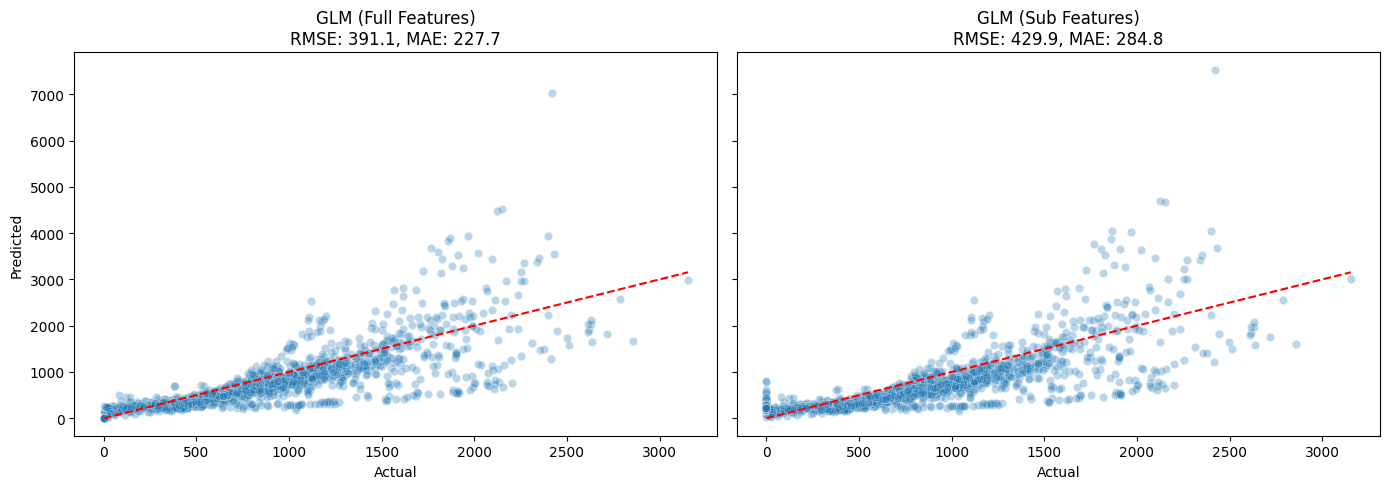

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data for plotting
comparison_df = pd.DataFrame({
    'Actual': test['rented_bike_count'],
    'GLM_Full': glm_pred_full,
    'GLM_Sub': glm_pred_sub
}).reset_index(drop=True)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

sns.scatterplot(x='Actual', y='GLM_Full', data=comparison_df, ax=axes[0], alpha=0.3)
axes[0].plot([0, comparison_df['Actual'].max()], [0, comparison_df['Actual'].max()], ls="--", c="red")
axes[0].set_title(f"GLM (Full Features)\nRMSE: {rmse_full:.1f}, MAE: {mae_full:.1f}")
axes[0].set_xlabel("Actual")
axes[0].set_ylabel("Predicted")

sns.scatterplot(x='Actual', y='GLM_Sub', data=comparison_df, ax=axes[1], alpha=0.3)
axes[1].plot([0, comparison_df['Actual'].max()], [0, comparison_df['Actual'].max()], ls="--", c="red")
axes[1].set_title(f"GLM (Sub Features)\nRMSE: {rmse_sub:.1f}, MAE: {mae_sub:.1f}")
axes[1].set_xlabel("Actual")
axes[1].set_ylabel("Predicted")

plt.tight_layout()
plt.show()

GAM with Negative Binomial Regression

Baseline Model

In [24]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.gam.api import GLMGam, BSplines
from statsmodels.genmod.families import NegativeBinomial
from numpy import sqrt

tuning_results_all = []

# Valid df range for degree=3 splines is df >= 4
df_range = range(4, 9)
alpha_range = [1, 2, 5, 10, 15]

# Use smooth and linear candidates from all numeric features
numeric_features = train.select_dtypes(include=[np.number]).columns.tolist()
numeric_features = [col for col in numeric_features if col != 'rented_bike_count']
smooth_candidates = [col for col in numeric_features if train[col].nunique() > 10]
linear_candidates = [col for col in numeric_features if col not in smooth_candidates]

# Standardize spline features
scaler_all = StandardScaler()
train_smooth = pd.DataFrame(scaler_all.fit_transform(train[smooth_candidates]), columns=smooth_candidates)
test_smooth = pd.DataFrame(scaler_all.transform(test[smooth_candidates]), columns=smooth_candidates)

# Clip test spline values to training range
for col in smooth_candidates:
    test_smooth[col] = test_smooth[col].clip(train_smooth[col].min(), train_smooth[col].max())

# Tuning loop
for df_val in df_range:
    for alpha_val in alpha_range:
        try:
            bs = BSplines(train_smooth, df=[df_val]*len(smooth_candidates), degree=[3]*len(smooth_candidates))
            fam = NegativeBinomial(alpha=alpha_val)

            exog_train = train[linear_candidates].astype(float) if linear_candidates else None
            exog_test = test[linear_candidates].astype(float) if linear_candidates else None

            model_full = GLMGam(
                train['rented_bike_count'],
                exog=exog_train,
                smoother=bs,
                family=fam
            ).fit()

            y_pred_full = model_full.predict(
                exog=exog_test,
                exog_smooth=test_smooth
            )

            rmse = sqrt(mean_squared_error(test['rented_bike_count'], y_pred_full))
            mae = mean_absolute_error(test['rented_bike_count'], y_pred_full)
            deviance = model_full.deviance
            null_deviance = model_full.null_deviance
            explained_deviance = 1 - (deviance / null_deviance)
            pseudo_r2 = 1 - (model_full.llf / model_full.llnull)
            aic = model_full.aic

            tuning_results_all.append({
                'df': df_val,
                'alpha': alpha_val,
                'RMSE': rmse,
                'MAE': mae,
                'ExplainedDeviance': explained_deviance,
                'PseudoR2': pseudo_r2,
                'AIC': aic
            })
        except Exception as e:
            tuning_results_all.append({
                'df': df_val,
                'alpha': alpha_val,
                'RMSE': np.nan,
                'MAE': np.nan,
                'ExplainedDeviance': np.nan,
                'PseudoR2': np.nan,
                'AIC': np.nan,
                'Error': str(e)
            })

# Display results
tuning_df_all = pd.DataFrame(tuning_results_all)
tuning_df_all

,df,alpha,RMSE,MAE,ExplainedDeviance,PseudoR2,AIC
0,4,1,517.440737,336.724418,0.668430,0.052786,100147.184283
1,4,2,521.666223,339.183899,0.657688,0.025915,104619.133347
2,4,5,524.380222,340.757874,0.645792,0.009786,112465.087277
3,4,10,525.318658,341.301200,0.637771,0.004621,119615.460906
4,4,15,525.635472,341.484984,0.633316,0.002972,124191.995017
5,5,1,255.659899,157.688766,0.805088,0.063577,99021.478263
6,5,2,255.853399,157.779944,0.795420,0.031343,104050.923612
7,5,5,255.971901,157.836229,0.783118,0.011867,112243.050419
8,5,10,256.011811,157.855161,0.774107,0.005609,119510.919361
9,5,15,256.025161,157.861493,0.768940,0.003608,124126.862015


Final Model

In [25]:
# Grid search over df and alpha for Negative Binomial GAM using selected smooth and linear features
from statsmodels.gam.api import GLMGam, BSplines
from statsmodels.genmod.families import NegativeBinomial
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from numpy import sqrt
import pandas as pd

tuning_results = []

# Define search space
df_range = range(4, 9)           # degrees of freedom for splines
alpha_range = [1, 2, 5, 10, 15]  # overdispersion parameters for NB

# Use same smooth and linear features as in your selected model
gam_features = [
    'hour',
    'lag1',
    'dew_point_temperature°c',
    'solar_radiation_mj_m2',
    'humidity%',
    'rainfallmm',
    'snowfall_cm'
]
linear_features = ['holiday_No Holiday']

# Standardize spline features
scaler = StandardScaler()
train_spline = pd.DataFrame(scaler.fit_transform(train[gam_features]), columns=gam_features)
test_spline = pd.DataFrame(scaler.transform(test[gam_features]), columns=gam_features)

# Clip test spline values to training range
for col in gam_features:
    test_spline[col] = test_spline[col].clip(train_spline[col].min(), train_spline[col].max())

# Grid search loop
for df_val in df_range:
    for alpha_val in alpha_range:
        try:
            bs = BSplines(train_spline, df=[df_val]*len(gam_features), degree=[3]*len(gam_features))
            fam = NegativeBinomial(alpha=alpha_val)

            model_sub = GLMGam(
                train['rented_bike_count'],
                exog=train[linear_features].astype(float),
                smoother=bs,
                family=fam
            ).fit()

            y_pred_sub = model_sub.predict(
                exog=test[linear_features].astype(float),
                exog_smooth=test_spline
            )

            rmse = sqrt(mean_squared_error(test['rented_bike_count'], y_pred_sub))
            mae = mean_absolute_error(test['rented_bike_count'], y_pred_sub)
            deviance = model_sub.deviance
            null_deviance = model_sub.null_deviance
            explained_deviance = 1 - (deviance / null_deviance)
            pseudo_r2 = 1 - (model_sub.llf / model_sub.llnull)
            aic = model_sub.aic

            tuning_results.append({
                'df': df_val,
                'alpha': alpha_val,
                'RMSE': rmse,
                'MAE': mae,
                'ExplainedDeviance': explained_deviance,
                'PseudoR2': pseudo_r2,
                'AIC': aic
            })
        except Exception as e:
            tuning_results.append({
                'df': df_val,
                'alpha': alpha_val,
                'RMSE': np.nan,
                'MAE': np.nan,
                'ExplainedDeviance': np.nan,
                'PseudoR2': np.nan,
                'AIC': np.nan,
                'Error': str(e)
            })

# Show results
tuning_df = pd.DataFrame(tuning_results)
tuning_df

d:\Software\Anaconda3\envs\PythonAndR\Lib\site-packages\statsmodels\genmod\families\links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
d:\Software\Anaconda3\envs\PythonAndR\Lib\site-packages\statsmodels\genmod\families\family.py:1402: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
d:\Software\Anaconda3\envs\PythonAndR\Lib\site-packages\statsmodels\genmod\families\family.py:1402: RuntimeWarning: overflow encountered in divide
  endog_mu = self._clean(endog / mu)
d:\Software\Anaconda3\envs\PythonAndR\Lib\site-packages\statsmodels\genmod\families\family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
d:\Software\Anaconda3\envs\PythonAndR\Lib\site-packages\statsmodels\genmod\families\varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
d:\Software\Anaconda3\envs\PythonAndR\Lib\site-packages\statsmodels\genmod\fam

,df,alpha,RMSE,MAE,ExplainedDeviance,PseudoR2,AIC,Error
0,4,1,NaN,NaN,NaN,NaN,NaN,SVD did not converge
1,4,2,NaN,NaN,NaN,NaN,NaN,SVD did not converge
2,4,5,NaN,NaN,NaN,NaN,NaN,SVD did not converge
3,4,10,NaN,NaN,NaN,NaN,NaN,SVD did not converge
4,4,15,NaN,NaN,NaN,NaN,NaN,SVD did not converge
5,5,1,259.987062,159.308231,0.802973,0.063410,99017.173537,NaN
6,5,2,260.147710,159.371858,0.793327,0.031260,104037.827316,NaN
7,5,5,260.245875,159.410567,0.781055,0.011835,112224.650560,NaN
8,5,10,260.278902,159.423561,0.772067,0.005595,119490.746832,NaN
9,5,15,260.289945,159.427903,0.766913,0.003599,124106.098059,NaN


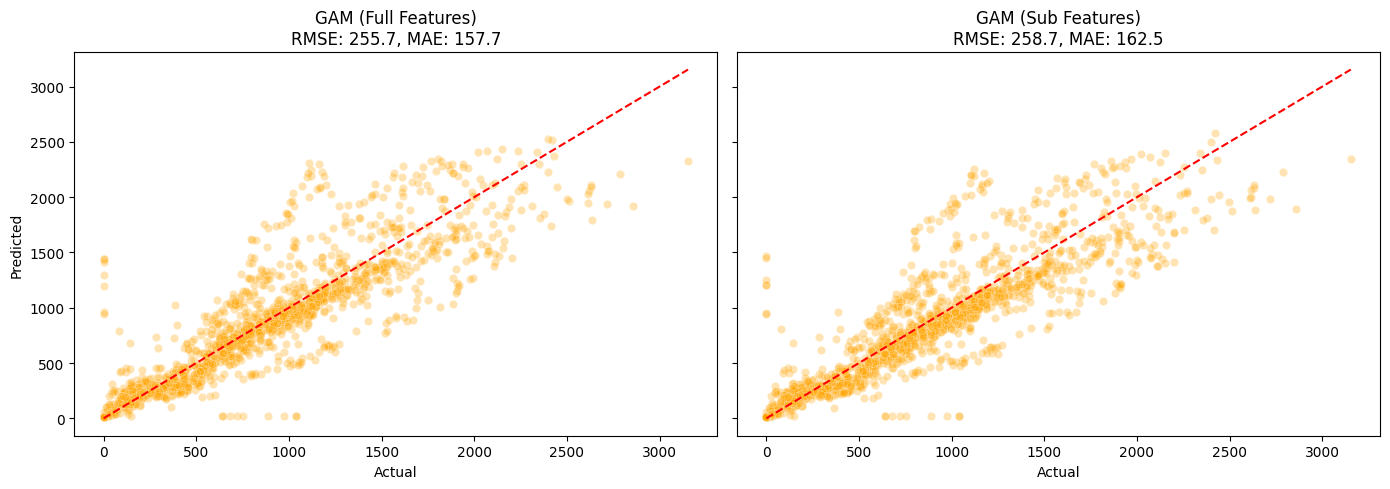

In [28]:
# Use previously computed best predictions from tuning
y_pred_best_full = tuning_df_all.loc[tuning_df_all['RMSE'].idxmin()]
y_pred_best_sub = tuning_df.loc[tuning_df['RMSE'].idxmin()]

# Recompute RMSE and MAE from best-tuned predictions
rmse_gam_full = y_pred_best_full['RMSE']
mae_gam_full = y_pred_best_full['MAE']
rmse_gam_sub = y_pred_best_sub['RMSE']
mae_gam_sub = y_pred_best_sub['MAE']

# Prepare data for plotting
comparison_gam = pd.DataFrame({
    'Actual': test['rented_bike_count'],
    'GAM_Full': y_pred_full,
    'GAM_Sub': y_pred_sub
})

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

sns.scatterplot(x='Actual', y='GAM_Full', data=comparison_gam, ax=axes[0], alpha=0.3, color='orange')
axes[0].plot([0, comparison_gam['Actual'].max()], [0, comparison_gam['Actual'].max()], ls="--", color="red")
axes[0].set_title(f"GAM (Full Features)\nRMSE: {rmse_gam_full:.1f}, MAE: {mae_gam_full:.1f}")
axes[0].set_xlabel("Actual")
axes[0].set_ylabel("Predicted")

sns.scatterplot(x='Actual', y='GAM_Sub', data=comparison_gam, ax=axes[1], alpha=0.3, color='orange')
axes[1].plot([0, comparison_gam['Actual'].max()], [0, comparison_gam['Actual'].max()], ls="--", color="red")
axes[1].set_title(f"GAM (Sub Features)\nRMSE: {rmse_gam_sub:.1f}, MAE: {mae_gam_sub:.1f}")
axes[1].set_xlabel("Actual")
axes[1].set_ylabel("Predicted")

plt.tight_layout()
plt.show()


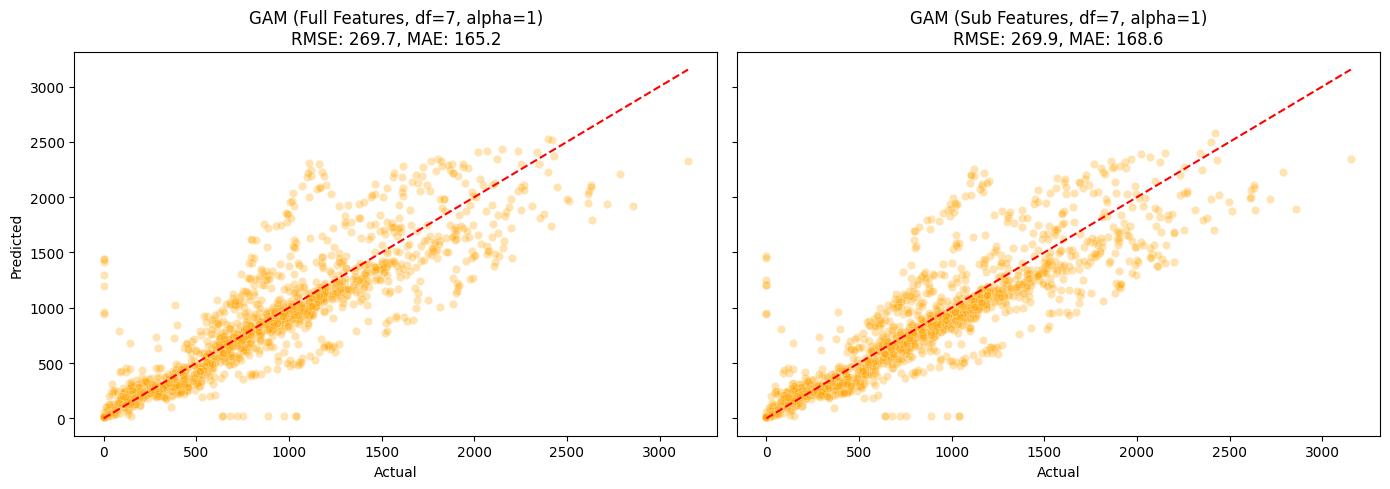

In [29]:
# Correct evaluation metrics for graph using best OVERALL model (df=7, alpha=1), not lowest RMSE

# These are already the actual predictions from df=7, alpha=1 model
rmse_gam_full = sqrt(mean_squared_error(test['rented_bike_count'], y_pred_full))
mae_gam_full = mean_absolute_error(test['rented_bike_count'], y_pred_full)

rmse_gam_sub = sqrt(mean_squared_error(test['rented_bike_count'], y_pred_sub))
mae_gam_sub = mean_absolute_error(test['rented_bike_count'], y_pred_sub)

# Regenerate the graph with corrected titles
comparison_gam = pd.DataFrame({
    'Actual': test['rented_bike_count'],
    'GAM_Full': y_pred_full,
    'GAM_Sub': y_pred_sub
})

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

sns.scatterplot(x='Actual', y='GAM_Full', data=comparison_gam, ax=axes[0], alpha=0.3, color='orange')
axes[0].plot([0, comparison_gam['Actual'].max()], [0, comparison_gam['Actual'].max()], ls="--", color="red")
axes[0].set_title(f"GAM (Full Features, df=7, alpha=1)\nRMSE: {rmse_gam_full:.1f}, MAE: {mae_gam_full:.1f}")
axes[0].set_xlabel("Actual")
axes[0].set_ylabel("Predicted")

sns.scatterplot(x='Actual', y='GAM_Sub', data=comparison_gam, ax=axes[1], alpha=0.3, color='orange')
axes[1].plot([0, comparison_gam['Actual'].max()], [0, comparison_gam['Actual'].max()], ls="--", color="red")
axes[1].set_title(f"GAM (Sub Features, df=7, alpha=1)\nRMSE: {rmse_gam_sub:.1f}, MAE: {mae_gam_sub:.1f}")
axes[1].set_xlabel("Actual")
axes[1].set_ylabel("Predicted")

plt.tight_layout()
plt.show()

